In [1]:
import numpy as np
import cv2
import urllib.request
import matplotlib.pyplot as plt

def url2img(url):
  req = urllib.request.urlopen(url)
  arr = np.asarray(bytearray(req.read()))
  return cv2.imdecode(arr, -1)



# A bit on color

(-0.5, 613.5, 479.5, -0.5)

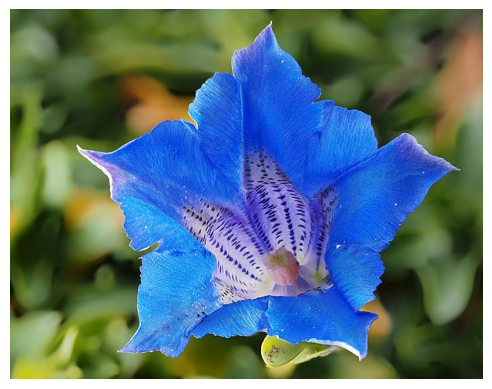

In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Gentiana_acaulis_%28stemless_gentian%29.jpg/614px-Gentiana_acaulis_%28stemless_gentian%29.jpg'
img = url2img(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

(-0.5, 613.5, 479.5, -0.5)

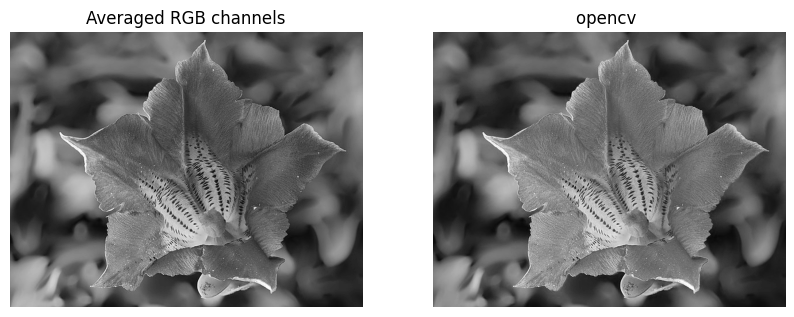

In [3]:
img_grayscale_0 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) /255. # opencv's conversion
img_grayscale_1 = (img / 255.).mean(axis=-1) # naive channel-wise average
img_diff = img_grayscale_1 - img_grayscale_0
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img_grayscale_0,cmap='gray',vmin=0,vmax=1.)
axes[0].set_title('Averaged RGB channels')
axes[1].imshow(img_grayscale_1,cmap='gray',vmin=0.,vmax=1.)
axes[1].set_title('opencv ')
axes[0].axis('off')
axes[1].axis('off')

#### Luminance formula ("Rec. 601" standard) : Y = 0.299⋅R  +  0.587⋅G  +  0.114⋅B


### The visible EM spectrum

![visible spectrum](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/EM_spectrum.svg/1200px-EM_spectrum.svg.png)

### The CIE 1931 chromaticity diagram
![cie1931xy](https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/CIE1931xy_CIERGB.svg/488px-CIE1931xy_CIERGB.svg.png)

!['cube'](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQNgiMLq1lDikZYa5z_wTXvyVwbYilEKq101uNKZ6wExLqEOazzZYaUKj5O60IqEE5DAic&usqp=CAU)

#### If you are interested in knowing more about it: https://www.youtube.com/watch?v=gnUYoQ1pwes

# A bit on morphology

Morphological operations can be used for many purposes, including hole-filling (part of assignment 1), edge detection, or skeletonizing an image.

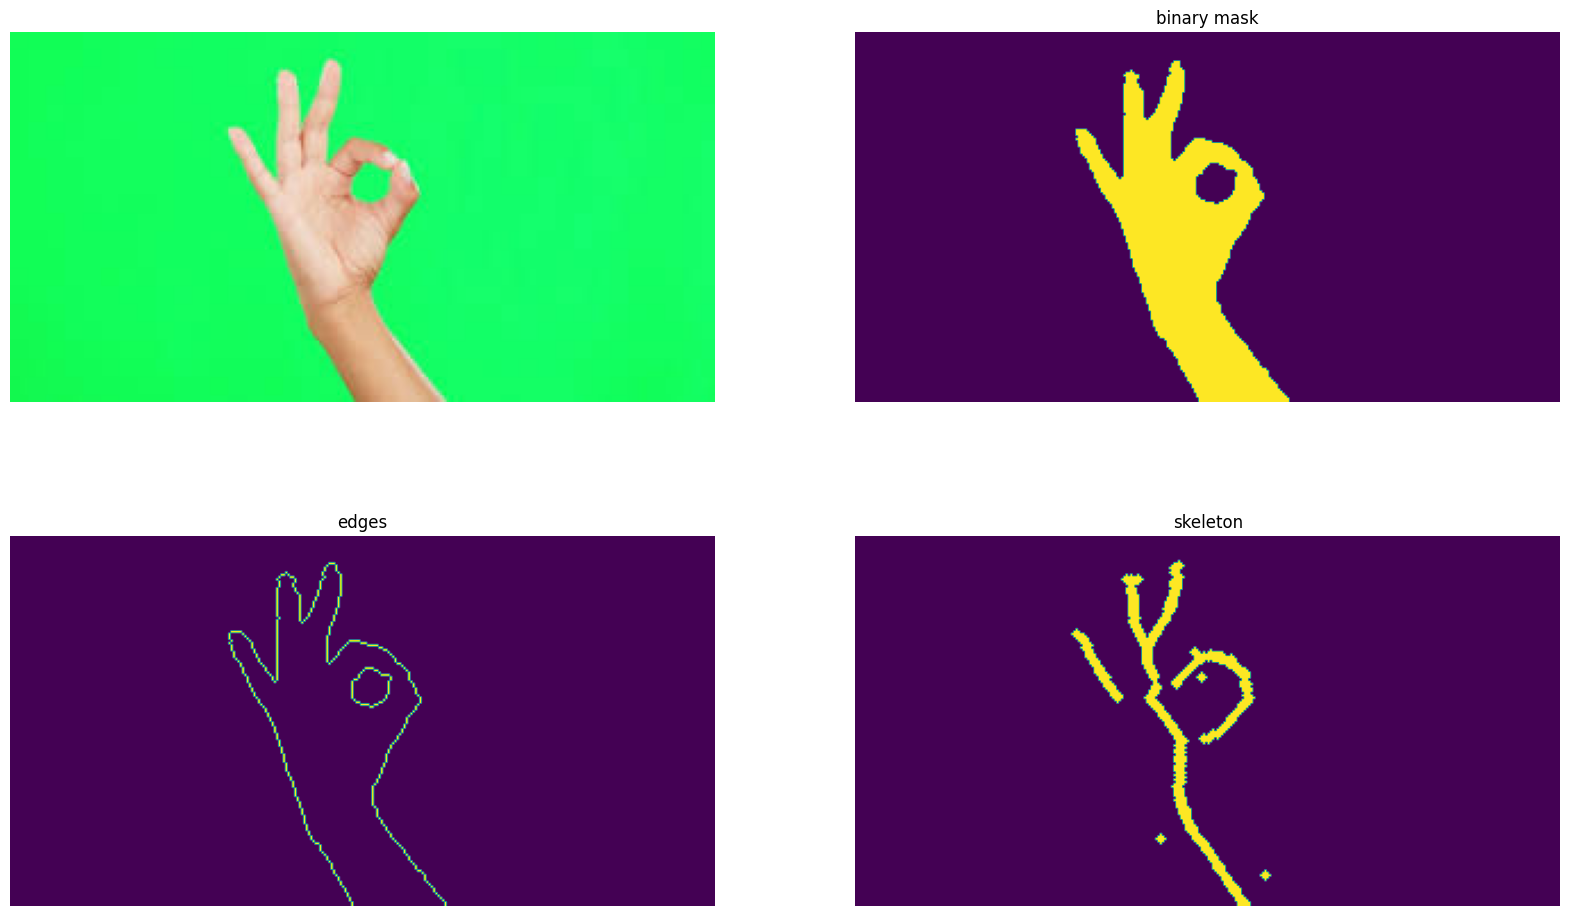

In [4]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcScHHdyIXXARr4Llb1qFhgWd-qPvTEo0x9PlQ&s'
img = url2img(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fix, axes = plt.subplots(2,2, figsize=(20,12))
axes[0,0].imshow(img)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

# masking by thresholding green channel 
mask = (255 * (img[:,:,1]<240)).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel, iterations=1)
axes[0,1].imshow(mask)
axes[0,1].set_title('binary mask')

# edge detection by dilation and difference
dil = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)
edges = dil-mask
axes[1,0].imshow(edges)
axes[1,0].set_title('edges')

# skeletonizing 
flag = False
size = np.size(mask) # number of pixels in the image
skel = np.zeros(mask.shape,np.uint8) # initialize skeleton

# succesively build the skeleton by adding the top hat of the binary mask
# succesively erode the mask until we reach an empty image
while( not flag):
    ero = cv2.erode(mask,kernel)
    opened = cv2.dilate(ero,kernel)
    top_hat = cv2.subtract(mask,opened) # the top hat operation
    skel = cv2.bitwise_or(skel,top_hat)
    mask = ero.copy()
 
    zeros = size - cv2.countNonZero(mask)
    if zeros==size:
        flag = True

# for visualization a thicker skeleton looks better
skel = cv2.morphologyEx(skel, cv2.MORPH_DILATE, kernel, iterations=2)
axes[1,1].imshow(skel)
axes[1,1].set_title('skeleton')

for ax in axes.ravel():
    ax.set_axis_off()





### Counting platelets
[Platelets](https://en.wikipedia.org/wiki/Platelet) are blood cells responsible for clotting and coagulation, therefore having a low count (or a very excessive count) of them is potentially life threatening. 

Platelets are the small purple dots in the image. Additionally, we can see white cells (the larger, purple cells), and red cells. Can we count them using morphology?

![platelets](https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Neutrophils.jpg/375px-Neutrophils.jpg)

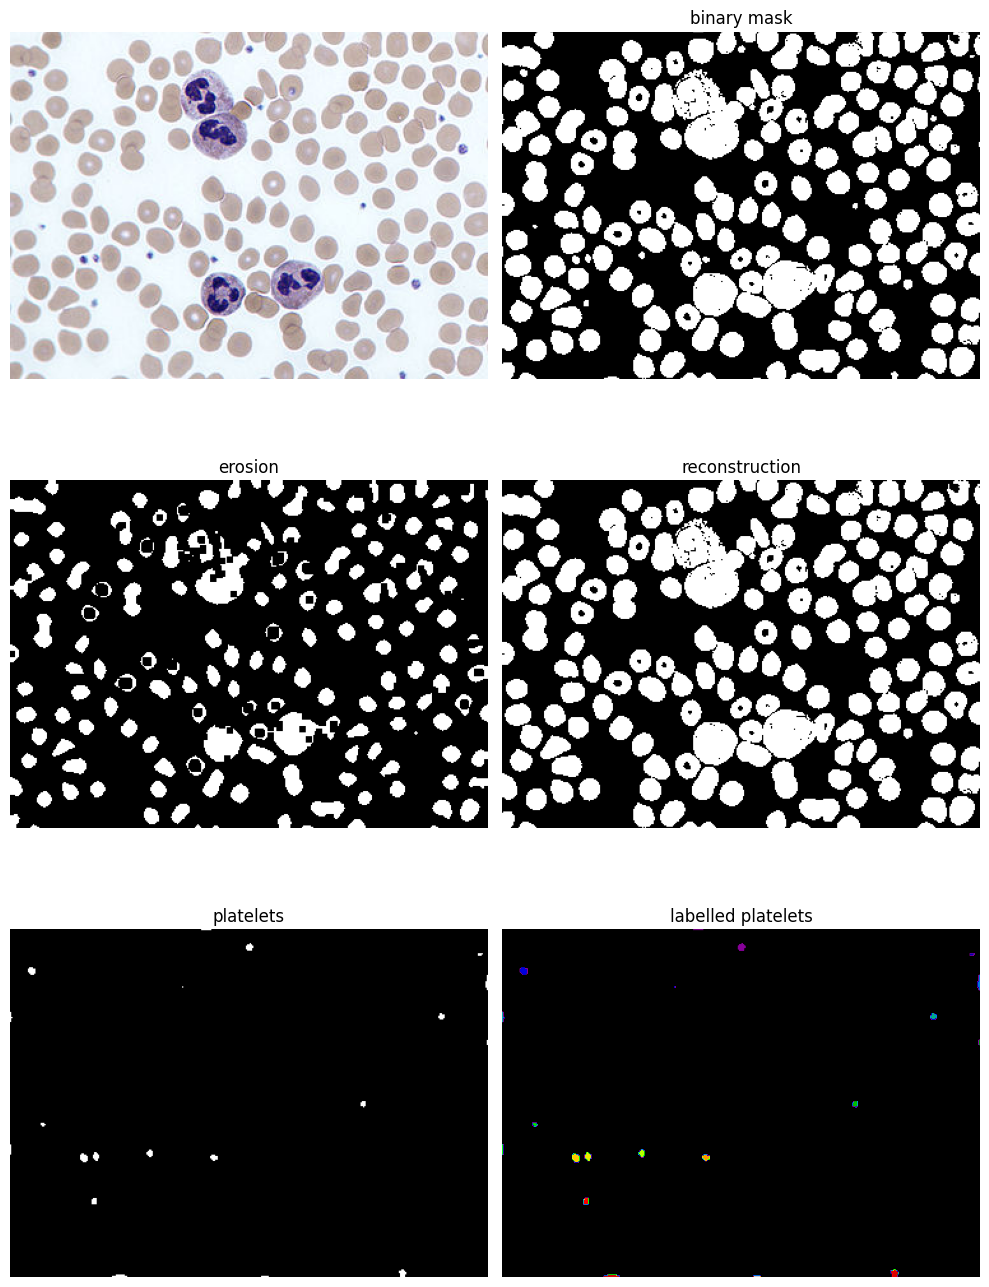

In [6]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Neutrophils.jpg/375px-Neutrophils.jpg'
img = url2img(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(3,2, figsize = (10,14))
axes[0,0].imshow(img)

# binarization by thresholding intensity
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_bin = 1. * (img_gray<200)
axes[0,1].imshow(img_bin, cmap='gray')
axes[0,1].set_title('binary mask')

# erosion to delete the platelets 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
ero = cv2.morphologyEx(img_bin, cv2.MORPH_ERODE, kernel, iterations=2)
axes[1,0].imshow(ero, cmap='gray')
axes[1,0].set_title('erosion')

# conditional dilation of ero with the original binary mask, to recover the objects that remained after erosion
# we do this procedure until convergence
flag = False
i=0
while not flag:
    ero_dil = cv2.morphologyEx(ero, cv2.MORPH_DILATE, kernel, iterations=1)
    new_ero = ero_dil * img_bin
    if np.all(new_ero==ero):
        flag = True
    i+=1
    ero = new_ero
axes[1,1].imshow(new_ero, cmap='gray')
axes[1,1].set_title('reconstruction')
platelets = img_bin - new_ero
axes[2,0].imshow(platelets, cmap='gray')
axes[2,0].set_title('platelets')

# labeling 
from skimage import measure
platelets_labels = measure.label(platelets, background=0)
axes[2,1].imshow(platelets_labels, cmap='nipy_spectral')
axes[2,1].set_title('labelled platelets')

for ax in axes.ravel():
    ax.set_axis_off()

plt.tight_layout()